# Лабораторная работа №1

### Разведочный анализ данных с помощью PySpark

### Цели и задачи:
1. Познакомиться с понятием «большие данные» и способами их обработки;
2. Познакомиться с инструментом Apache Spark и возможностями, которые он предоставляет для обработки больших данных;
3. Получить навыки выполнения разведочного анализа данных использованием pyspark.


# Ход работы

In [78]:
# Import other modules not related to PySpark
import os
import sys
import pandas as pd
from pandas import DataFrame
import numpy as np
import matplotlib.pyplot as plt
import matplotlib.ticker as mtick
import matplotlib
from mpl_toolkits.mplot3d import Axes3D
import math
from IPython.core.interactiveshell import InteractiveShell
from datetime import *
import statistics as stats
# This helps auto print out the items without explixitly using 'print'
InteractiveShell.ast_node_interactivity = "all" 
%matplotlib inline

# Обзор датасета

In [79]:
# Import PySpark related modules
import pyspark
from pyspark.rdd import RDD
from pyspark.sql import Row
from pyspark.sql import DataFrame
from pyspark.sql import SparkSession
from pyspark.sql import SQLContext
from pyspark.sql import functions
from pyspark.sql.functions import lit, desc, col, size, array_contains\
, isnan, udf, hour, array_min, array_max, countDistinct
from pyspark.sql.types import *

MAX_MEMORY = '15G'
# Initialize a spark session.
conf = pyspark.SparkConf().setMaster("local[*]") \
        .set('spark.executor.heartbeatInterval', 10000) \
        .set('spark.network.timeout', 10000) \
        .set("spark.core.connection.ack.wait.timeout", "3600") \
        .set("spark.executor.memory", MAX_MEMORY) \
        .set("spark.driver.memory", MAX_MEMORY)
def init_spark():
    spark = SparkSession \
        .builder \
        .appName("Pyspark guide") \
        .config(conf=conf) \
        .getOrCreate()
    return spark

spark = init_spark()
# Укажите путь к CSV файлу
csv_file_path = "itineraries.csv"

# Прочитайте CSV файл в DataFrame
df = spark.read.csv(csv_file_path, header=True, sep=',', inferSchema=True)

drop_columns = ['legId', 'fareBasisCode', 'segmentsCabinCode', 'segmentsDepartureTimeEpochSeconds', 'segmentsDepartureTimeRaw', 'segmentsArrivalTimeEpochSeconds',
                'segmentsArrivalTimeRaw', 'segmentsArrivalAirportCode', 'segmentsDepartureAirportCode', 'segmentsAirlineName', 'segmentsAirlineCode', 'segmentsEquipmentDescription',
               'segmentsDurationInSeconds', 'segmentsDistance', 'segmentsCabinCode']

df = df.select([col for col in df.columns if col not in drop_columns])

limited_data_pandas = df.limit(10)

limited_data_pandas.toPandas()

,searchDate,flightDate,startingAirport,destinationAirport,travelDuration,elapsedDays,isBasicEconomy,isRefundable,isNonStop,baseFare,totalFare,seatsRemaining,totalTravelDistance
0,2022-04-16,2022-04-17,ATL,BOS,PT2H29M,0,False,False,True,217.67,248.6,9,947
1,2022-04-16,2022-04-17,ATL,BOS,PT2H30M,0,False,False,True,217.67,248.6,4,947
2,2022-04-16,2022-04-17,ATL,BOS,PT2H30M,0,False,False,True,217.67,248.6,9,947
3,2022-04-16,2022-04-17,ATL,BOS,PT2H32M,0,False,False,True,217.67,248.6,8,947
4,2022-04-16,2022-04-17,ATL,BOS,PT2H34M,0,False,False,True,217.67,248.6,9,947
5,2022-04-16,2022-04-17,ATL,BOS,PT2H38M,0,False,False,True,217.67,248.6,7,947
6,2022-04-16,2022-04-17,ATL,BOS,PT4H12M,0,False,False,False,213.02,251.1,3,956
7,2022-04-16,2022-04-17,ATL,BOS,PT5H18M,0,False,False,False,213.02,251.1,3,956
8,2022-04-16,2022-04-17,ATL,BOS,PT5H32M,0,False,False,False,213.02,251.1,7,956
9,2022-04-16,2022-04-17,ATL,BOS,PT6H38M,0,False,False,False,213.02,251.1,7,956


# Преобразование длительности полета в числовое значение (минуты полета)

In [80]:
from pyspark.sql.functions import col, regexp_extract
# Функция для преобразования формата "PT2H29M" в минуты и записи в новую колонку
def convert_duration_to_minutes(df, column):
    # Извлекаем часы и минуты из строки
    hours = regexp_extract(col(column), r'PT(\d+)H', 1).cast('int')
    minutes = regexp_extract(col(column), r'(\d+)M', 1).cast('int')
    
    # Выполняем необходимые вычисления
    minutes_in_total = hours * 60 + minutes
    
    # Добавляем новую колонку
    df = df.withColumn(f"{column}_inMinutes", minutes_in_total)
    
    return df

# Применяем функцию для указанной колонки "travelDuration"
df = convert_duration_to_minutes(df, "travelDuration")

df = df.drop("travelDuration")

# Печатаем DataFrame с новой колонкой
limited_data_pandas = df.limit(10)

limited_data_pandas.toPandas()

,searchDate,flightDate,startingAirport,destinationAirport,elapsedDays,isBasicEconomy,isRefundable,isNonStop,baseFare,totalFare,seatsRemaining,totalTravelDistance,travelDuration_inMinutes
0,2022-04-16,2022-04-17,ATL,BOS,0,False,False,True,217.67,248.6,9,947,149
1,2022-04-16,2022-04-17,ATL,BOS,0,False,False,True,217.67,248.6,4,947,150
2,2022-04-16,2022-04-17,ATL,BOS,0,False,False,True,217.67,248.6,9,947,150
3,2022-04-16,2022-04-17,ATL,BOS,0,False,False,True,217.67,248.6,8,947,152
4,2022-04-16,2022-04-17,ATL,BOS,0,False,False,True,217.67,248.6,9,947,154
5,2022-04-16,2022-04-17,ATL,BOS,0,False,False,True,217.67,248.6,7,947,158
6,2022-04-16,2022-04-17,ATL,BOS,0,False,False,False,213.02,251.1,3,956,252
7,2022-04-16,2022-04-17,ATL,BOS,0,False,False,False,213.02,251.1,3,956,318
8,2022-04-16,2022-04-17,ATL,BOS,0,False,False,False,213.02,251.1,7,956,332
9,2022-04-16,2022-04-17,ATL,BOS,0,False,False,False,213.02,251.1,7,956,398


In [81]:
# # Функция для преобразования формата "PT2H29M" в минуты
# def parse_duration(duration_str):
#     # Извлекаем часы и минуты из строки формата "PT2H29M"
#     hours_start = duration_str.find("H")
#     minutes_start = duration_str.find("M")

#     hours = int(duration_str[2:hours_start]) if hours_start != -1 else 0
#     minutes = int(duration_str[hours_start + 2:minutes_start]) if minutes_start != -1 else 0

#     # Вычисляем общее количество минут
#     total_minutes = hours * 60 + minutes
#     return total_minutes

# # Регистрируем функцию в качестве UDF
# parse_duration_udf = udf(parse_duration, IntegerType())

# # Применяем UDF к колонке "travelDuration" и создаем новую колонку "durationInMinutes"
# df = df.withColumn("travelDurationInMinutes", parse_duration_udf("travelDuration"))

# df = df.drop("travelDuration")

# limited_data_pandas = df.limit(10)
# limited_data_pandas.toPandas()

# Поиск и удаление пустых значений

In [82]:
for col_name in df.columns:
    count_missing = df.filter(col(col_name).isNull()).count()
    print(f"Количество пустых значений в колонке '{col_name}': {count_missing}")


Количество пустых значений в колонке 'searchDate': 0
Количество пустых значений в колонке 'flightDate': 0
Количество пустых значений в колонке 'startingAirport': 1
Количество пустых значений в колонке 'destinationAirport': 1
Количество пустых значений в колонке 'elapsedDays': 1
Количество пустых значений в колонке 'isBasicEconomy': 1
Количество пустых значений в колонке 'isRefundable': 1
Количество пустых значений в колонке 'isNonStop': 1
Количество пустых значений в колонке 'baseFare': 1
Количество пустых значений в колонке 'totalFare': 1
Количество пустых значений в колонке 'seatsRemaining': 1
Количество пустых значений в колонке 'totalTravelDistance': 1004282
Количество пустых значений в колонке 'travelDuration_inMinutes': 307814


In [83]:
# Удаляем строки с пустыми значениями
df = df.na.drop()

for col_name in df.columns:
    count_missing = df.filter(col(col_name).isNull()).count()
    print(f"Количество пустых значений в колонке '{col_name}': {count_missing}")

Количество пустых значений в колонке 'searchDate': 0
Количество пустых значений в колонке 'flightDate': 0
Количество пустых значений в колонке 'startingAirport': 0
Количество пустых значений в колонке 'destinationAirport': 0
Количество пустых значений в колонке 'elapsedDays': 0
Количество пустых значений в колонке 'isBasicEconomy': 0
Количество пустых значений в колонке 'isRefundable': 0
Количество пустых значений в колонке 'isNonStop': 0
Количество пустых значений в колонке 'baseFare': 0
Количество пустых значений в колонке 'totalFare': 0
Количество пустых значений в колонке 'seatsRemaining': 0
Количество пустых значений в колонке 'totalTravelDistance': 0
Количество пустых значений в колонке 'travelDuration_inMinutes': 0


# Определение типов данных колонок

In [84]:
# Печатаем типы данных для каждой колонки
for col_name, col_type in df.dtypes:
    print(f"Тип данных для колонки '{col_name}': {col_type}")

Тип данных для колонки 'searchDate': date
Тип данных для колонки 'flightDate': string
Тип данных для колонки 'startingAirport': string
Тип данных для колонки 'destinationAirport': string
Тип данных для колонки 'elapsedDays': int
Тип данных для колонки 'isBasicEconomy': boolean
Тип данных для колонки 'isRefundable': boolean
Тип данных для колонки 'isNonStop': boolean
Тип данных для колонки 'baseFare': double
Тип данных для колонки 'totalFare': double
Тип данных для колонки 'seatsRemaining': int
Тип данных для колонки 'totalTravelDistance': int
Тип данных для колонки 'travelDuration_inMinutes': int


In [85]:
# Проверяем наличие значений других типов в колонке "ID" с типом "int"
non_int_values = df.filter(~col("travelDuration_inMinutes").cast("int").isNotNull())

# Печатаем строки с значениями других типов в колонке "ID"
limited_data_pandas = non_int_values.limit(10)
limited_data_pandas.toPandas()
# non_int_values.show()

,searchDate,flightDate,startingAirport,destinationAirport,elapsedDays,isBasicEconomy,isRefundable,isNonStop,baseFare,totalFare,seatsRemaining,totalTravelDistance,travelDuration_inMinutes


# Поиск и удаление выбросов

In [86]:
from pyspark.sql.functions import col

# Колонки для поиска выбросов
numeric_columns = ['elapsedDays', 'baseFare', 'totalFare', 'seatsRemaining', 'totalTravelDistance']

# Параметр выбросов
outlier_threshold = 1.5

# Function to remove outliers using IQR
def remove_outliers(df, column):
    quantiles = df.approxQuantile(column, [0.25, 0.75], 0.01)
    lower_bound = quantiles[0] - outlier_threshold * (quantiles[1] - quantiles[0])
    upper_bound = quantiles[1] + outlier_threshold * (quantiles[1] - quantiles[0])
    
    # Filter and count outliers
    outliers_count = df.filter((col(column) < lower_bound) | (col(column) > upper_bound)).count()
    
    # Remove outliers
    df = df.filter((col(column) >= lower_bound) & (col(column) <= upper_bound))
    
    return df, outliers_count

# Remove outliers for each numeric column
outliers_stats = {}
for column in numeric_columns:
    df, outliers_count = remove_outliers(df, column)
    outliers_stats[column] = outliers_count

# Show the cleaned DataFrame
limited_data_pandas = df.limit(10)
print(limited_data_pandas.toPandas())

# Print the outliers statistics
for column, count in outliers_stats.items():
    print(f"Выбросы удалены для {column}: {count}")

   searchDate  flightDate startingAirport destinationAirport  elapsedDays  \
0  2022-04-16  2022-04-17             ATL                BOS            0   
1  2022-04-16  2022-04-17             ATL                BOS            0   
2  2022-04-16  2022-04-17             ATL                BOS            0   
3  2022-04-16  2022-04-17             ATL                BOS            0   
4  2022-04-16  2022-04-17             ATL                BOS            0   
5  2022-04-16  2022-04-17             ATL                BOS            0   
6  2022-04-16  2022-04-17             ATL                BOS            0   
7  2022-04-16  2022-04-17             ATL                BOS            0   
8  2022-04-16  2022-04-17             ATL                BOS            0   
9  2022-04-16  2022-04-17             ATL                BOS            0   

   isBasicEconomy  isRefundable  isNonStop  baseFare  totalFare  \
0           False         False       True    217.67      248.6   
1           False 

# Расчет статистических показателей

In [87]:
# Используем метод describe для расчета статистических показателей
# statistics = df.describe()

# Можно также использовать метод summary для более подробной информации
summary = df.summary()
summary.show()

+-------+----------+---------------+------------------+-----------+------------------+------------------+-----------------+-------------------+------------------------+
|summary|flightDate|startingAirport|destinationAirport|elapsedDays|          baseFare|         totalFare|   seatsRemaining|totalTravelDistance|travelDuration_inMinutes|
+-------+----------+---------------+------------------+-----------+------------------+------------------+-----------------+-------------------+------------------------+
|  count|  10665541|       10665541|          10665541|   10665541|          10665541|          10665541|         10665541|           10665541|                10665541|
|   mean|      NULL|           NULL|              NULL|        0.0|311.07436904419166| 355.6855877018022|6.057715872078125| 1454.6771289895187|      372.24434025428246|
| stddev|      NULL|           NULL|              NULL|        0.0|157.74020037057946|171.76641957058175|2.642871987058044|   801.534637057749|      197.57

# Корреляция признаков

In [90]:
# Выбираем нужные колонки
selected_columns = ["elapsedDays", "baseFare", "totalFare", "seatsRemaining", "totalTravelDistance", "travelDuration_inMinutes"]

# Подсчет корреляции
correlation_matrix = df.select(selected_columns).toPandas().corr()

# Печатаем матрицу корреляции
print("Матрица корреляции:")
correlation_matrix

Correlation Matrix:


,elapsedDays,baseFare,totalFare,seatsRemaining,totalTravelDistance,travelDuration_inMinutes
elapsedDays,NaN,NaN,NaN,NaN,NaN,NaN
baseFare,NaN,1.000000,0.999588,-0.055005,0.605832,0.532262
totalFare,NaN,0.999588,1.000000,-0.059220,0.610485,0.551813
seatsRemaining,NaN,-0.055005,-0.059220,1.000000,-0.081195,-0.144556
totalTravelDistance,NaN,0.605832,0.610485,-0.081195,1.000000,0.715439
travelDuration_inMinutes,NaN,0.532262,0.551813,-0.144556,0.715439,1.000000


# Визуализация параметра "Цена билета"

<Axes: xlabel='totalFare', ylabel='Count'>

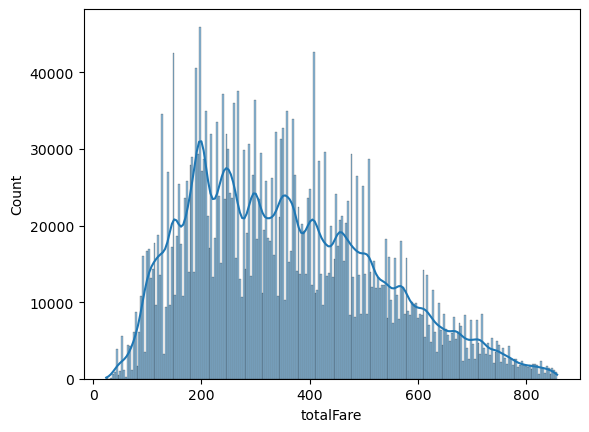

In [95]:
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns

# Преобразование PySpark DataFrame в Pandas DataFrame
pandas_df = df.sample(fraction=0.3, seed=42).toPandas()

# Создание гистограммы и KDE для признака 'actual_consumption' с использованием Pandas и Seaborn
sns.histplot(data=pandas_df, x='totalFare', kde=True)
plt.show()

# Визуализация параметра "Длительность полета"

<Axes: xlabel='travelDuration_inMinutes', ylabel='Count'>

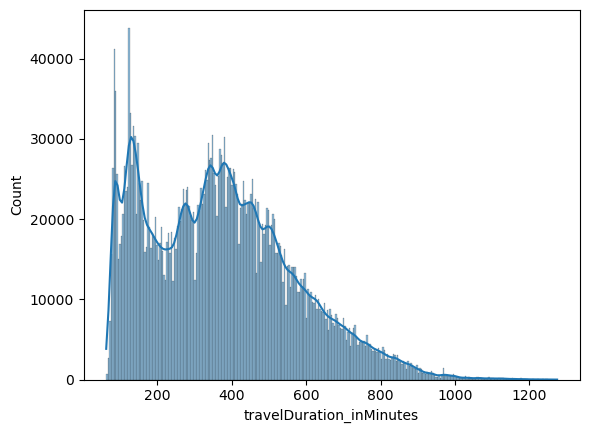

In [96]:
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns

# Преобразование PySpark DataFrame в Pandas DataFrame
pandas_df = df.sample(fraction=0.3, seed=42).toPandas()

# Создание гистограммы и KDE для признака 'actual_consumption' с использованием Pandas и Seaborn
sns.histplot(data=pandas_df, x='travelDuration_inMinutes', kde=True)
plt.show()